# Experiment description
## Hypothesis: 
We can predict with an average hitrate higher than 0.1 (10% coverage) the aggressive behavior occurrence over a week.

## Method: 

Estimate hitrates over predictions between 2017-01-22 and 2017-01-29. Experiment parameters:
- Use city trained model between 2017-01-01 and 2017-01-21
- Predict for each day in the following hours: [3, 9, 15, 21]
- Estimate hitrate and PAI using 5% and 10% coverage
- Estimate average PAI

In [1]:
%matplotlib inline
import pandas as pd
import pickle
import dateutil.parser
import pyproj
import open_cp
from PIL import Image
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import import_ipynb
import training_sepp_builtin

importing Jupyter notebook from training_sepp_builtin.ipynb
  Using cached https://github.com/QuantCrimAtLeeds/PredictCode/zipball/master
  Created wheel for opencp: filename=opencp-0.2.0-cp37-none-any.whl size=280058 sha256=01e613559bf444fd44f99edbb4c35fd9b1bc5c8150e639452cf80c9562f3c3c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-0wvnwlui/wheels/9a/f6/1f/9ea8bd2ac044e7df5c432f658ba156f0cfc3540891a5bad62a
Successfully built opencp
  Using cached https://github.com/MatthewDaws/SEPP/zipball/master
  Created wheel for sepp: filename=sepp-0.9.0-cp37-none-any.whl size=37591 sha256=9f97f36f45af76609d2c357e3d541ff10e7f3bf4ce686909996ab6d91e0d61c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-37yvbt4s/wheels/1d/e6/94/444aa295403d7f0e2ffd698d822abc6a4427daa85f8c5cb0b0
Successfully built sepp


Failed to load 'descartes' package.


In [64]:
def selectDataPrediction(nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
            
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))
    print([timestamps])

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_crime = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    
    #Generando Grilla para los algoritmos. 
    maxx = max(xcoords)
    minx = min(xcoords)
    maxy = max(ycoords)
    miny = min(ycoords)
    #print(maxx,minx,maxy,miny)

    region = open_cp.RectangularRegion(xmin=minx, xmax=maxx, ymin=miny, ymax=maxy)
    #print(region)
    
    return (points_crime,region)


In [65]:
def load_model(localidad, experiment_name):
    custom_path = path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl'
    infile = open(custom_path,'rb')
    modelCrime = pickle.load(infile)
    infile.close()
    return modelCrime

In [68]:
def run_prediction(localidad,modelCrime,time_window_prediction,predict_time):
    points_crime,region = selectDataPrediction(localidad,time_window_prediction['start'],time_window_prediction['end'])
    modelCrime.data = points_crime 
    prediction = modelCrime.predict(predict_time)
    gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 150, 150)
    hitrates = open_cp.evaluation.hit_rates(gridpred, points_crime, [0.05,0.1])
    return gridpred, hitrates

In [69]:
def plot_gridpred(localidad,predict_time,gridpred):
    fig, ax = plt.subplots(figsize=(20,10))
    m = ax.pcolormesh(*gridpred.mesh_data(), gridpred.intensity_matrix, cmap="CMRmap_r")
    ax.set_title("Predicción localidad: "+localidad+'; fecha: '+str(predict_time))
    fig.colorbar(m, ax=ax)

## Select data

In [6]:
path = '/u01/user8/Documents/Riñas'

In [18]:
df = pd.read_csv(path+'/datasets/verify_enrich_nuse_29112019.csv')

## Test prediction

In [7]:
localidad = 'city'
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":90,"space_cutoff":500}
train_initial_date = '2017-01-01'
train_final_date = '2017-01-22'
trained_model_name = str(localidad)+'_'+train_initial_date+'_'+train_final_date+'_time_cutoff_'+str(parameters['time_cutoff'])

In [8]:
initial_date_prediction = '2017-01-22'
final_date_prediction = '2017-01-29'

In [70]:
dates_to_predict = []
for i in range(7):
    current_datetime = datetime.datetime.strptime(initial_date_prediction,'%Y-%m-%d')+datetime.timedelta(days=i)
    dates_to_predict.append(current_datetime.strftime('%Y-%m-%d'))
    
dates_to_predict

['2017-01-22',
 '2017-01-23',
 '2017-01-24',
 '2017-01-25',
 '2017-01-26',
 '2017-01-27',
 '2017-01-28']

TimeStamps
<class 'pandas.core.series.Series'>
[3212     2017-01-22 02:04:00
3217     2017-01-22 00:37:00
3218     2017-01-22 14:50:00
3219     2017-01-22 10:47:00
3220     2017-01-22 11:28:00
                 ...        
700988   2017-01-22 17:06:00
700989   2017-01-22 15:33:00
700990   2017-01-22 13:43:00
700991   2017-01-22 18:06:00
700997   2017-01-22 02:33:00
Name: FECHA_HORA_TS, Length: 1544, dtype: datetime64[ns]]
TimeStamps
<class 'pandas.core.series.Series'>
[3212     2017-01-22 02:04:00
3217     2017-01-22 00:37:00
3218     2017-01-22 14:50:00
3219     2017-01-22 10:47:00
3220     2017-01-22 11:28:00
                 ...        
700988   2017-01-22 17:06:00
700989   2017-01-22 15:33:00
700990   2017-01-22 13:43:00
700991   2017-01-22 18:06:00
700997   2017-01-22 02:33:00
Name: FECHA_HORA_TS, Length: 1544, dtype: datetime64[ns]]
TimeStamps
<class 'pandas.core.series.Series'>
[3212     2017-01-22 02:04:00
3217     2017-01-22 00:37:00
3218     2017-01-22 14:50:00
3219     2017-0

TimeStamps
<class 'pandas.core.series.Series'>
[3889     2017-01-27 18:07:00
3890     2017-01-27 00:07:00
3891     2017-01-27 08:08:00
3892     2017-01-27 21:04:00
3893     2017-01-27 11:16:00
                 ...        
701401   2017-01-27 19:21:00
701402   2017-01-27 16:57:00
701403   2017-01-27 03:43:00
701404   2017-01-27 11:59:00
701405   2017-01-27 21:42:00
Name: FECHA_HORA_TS, Length: 856, dtype: datetime64[ns]]


/u01/user8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


TimeStamps
<class 'pandas.core.series.Series'>
[3889     2017-01-27 18:07:00
3890     2017-01-27 00:07:00
3891     2017-01-27 08:08:00
3892     2017-01-27 21:04:00
3893     2017-01-27 11:16:00
                 ...        
701401   2017-01-27 19:21:00
701402   2017-01-27 16:57:00
701403   2017-01-27 03:43:00
701404   2017-01-27 11:59:00
701405   2017-01-27 21:42:00
Name: FECHA_HORA_TS, Length: 856, dtype: datetime64[ns]]
TimeStamps
<class 'pandas.core.series.Series'>
[3889     2017-01-27 18:07:00
3890     2017-01-27 00:07:00
3891     2017-01-27 08:08:00
3892     2017-01-27 21:04:00
3893     2017-01-27 11:16:00
                 ...        
701401   2017-01-27 19:21:00
701402   2017-01-27 16:57:00
701403   2017-01-27 03:43:00
701404   2017-01-27 11:59:00
701405   2017-01-27 21:42:00
Name: FECHA_HORA_TS, Length: 856, dtype: datetime64[ns]]
TimeStamps
<class 'pandas.core.series.Series'>
[3889     2017-01-27 18:07:00
3890     2017-01-27 00:07:00
3891     2017-01-27 08:08:00
3892     2017-01-

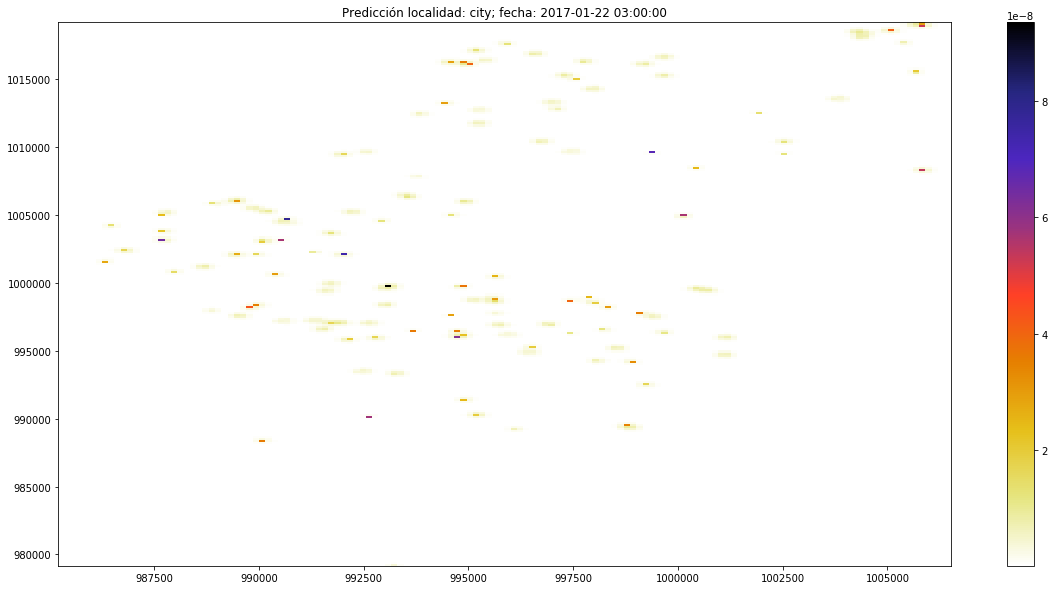

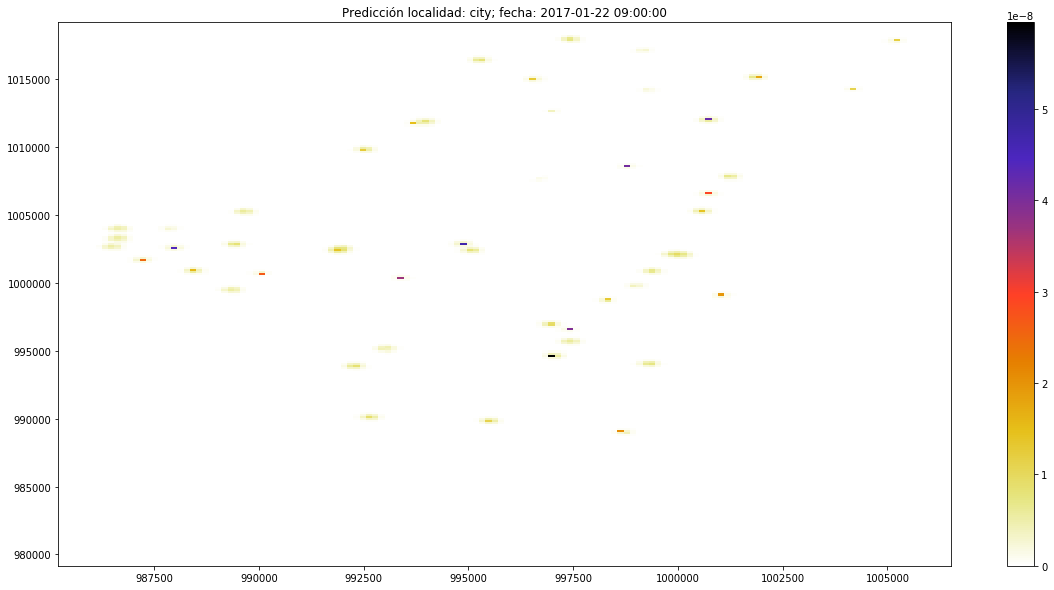

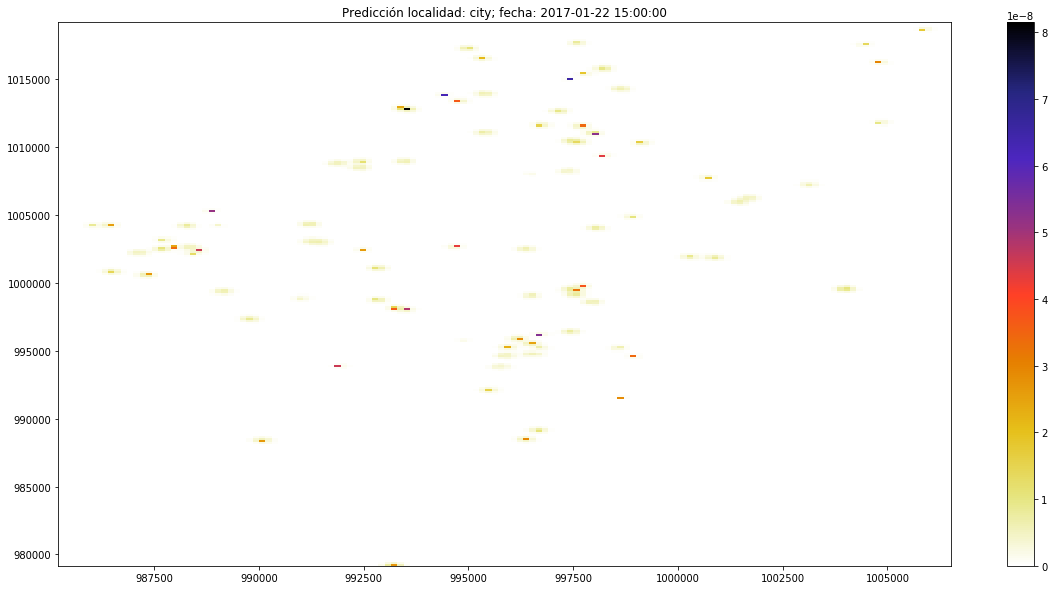

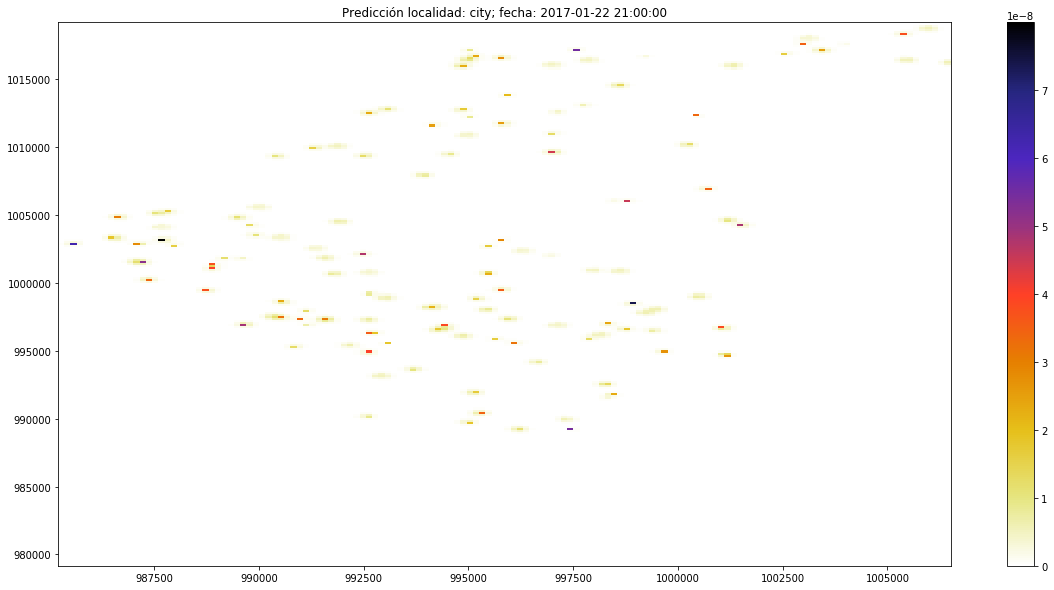

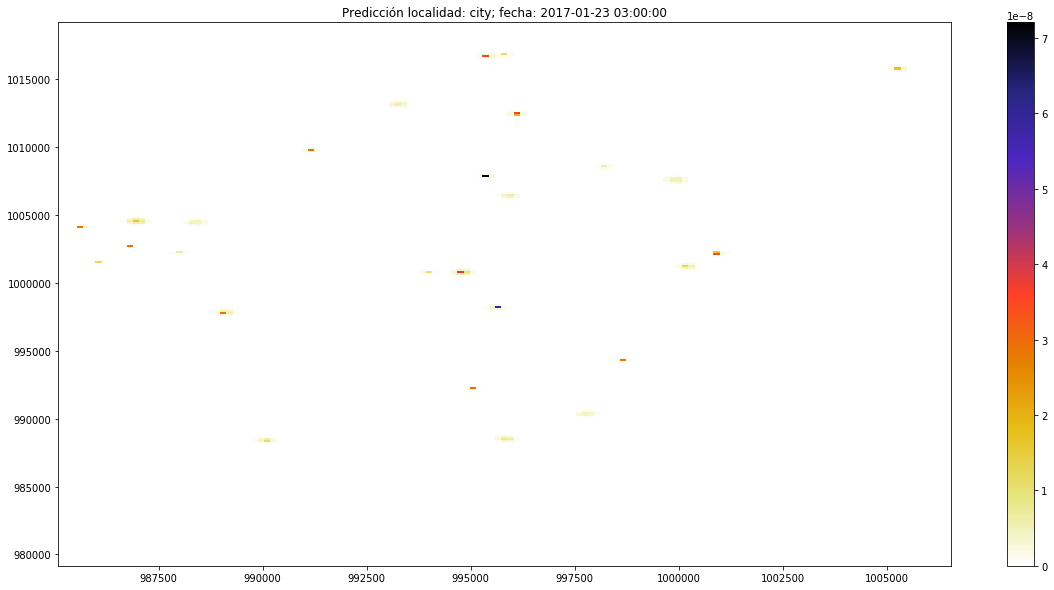

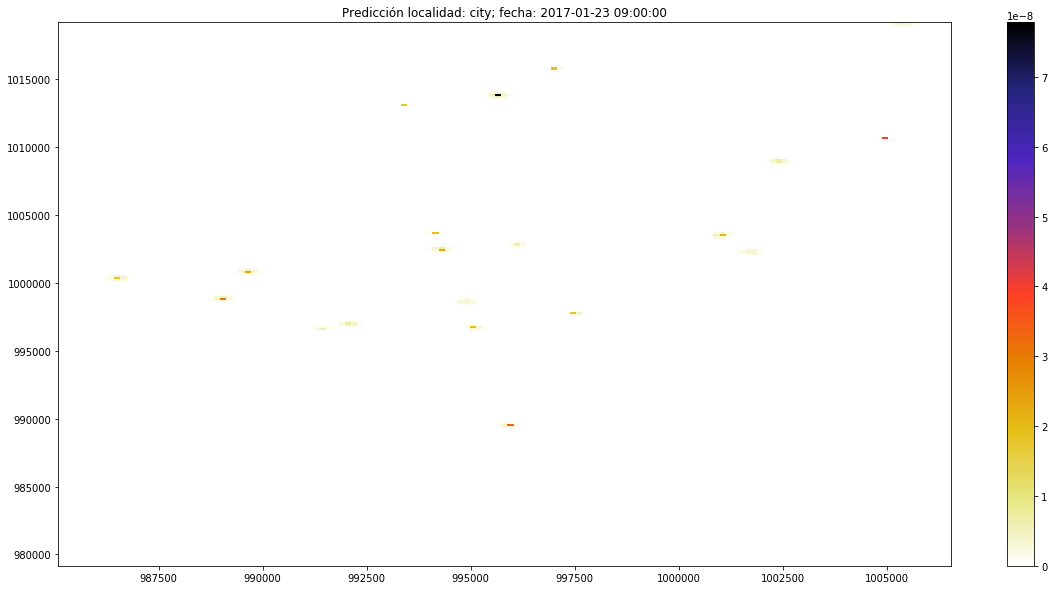

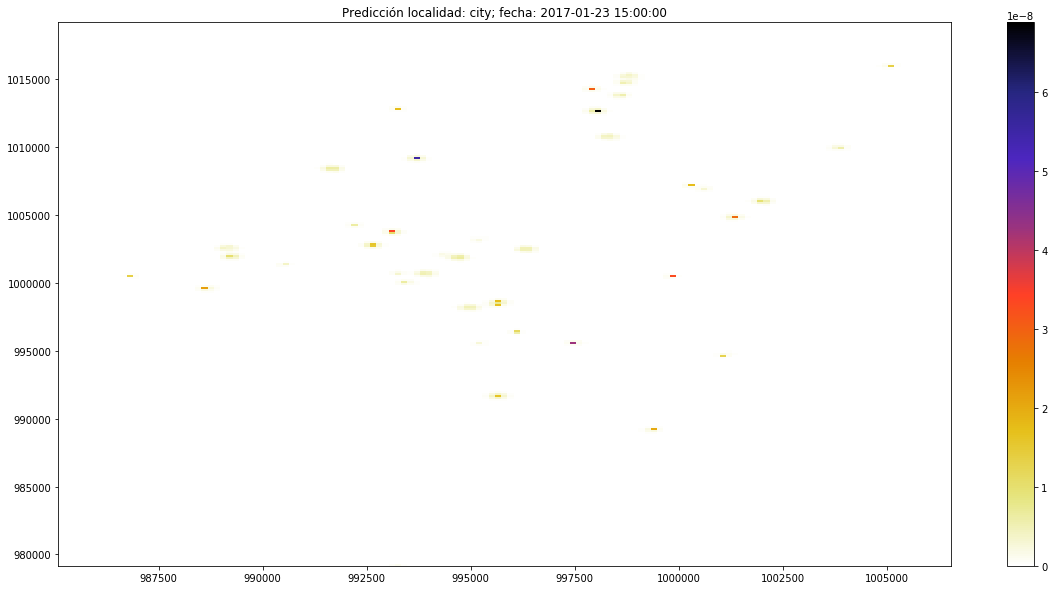

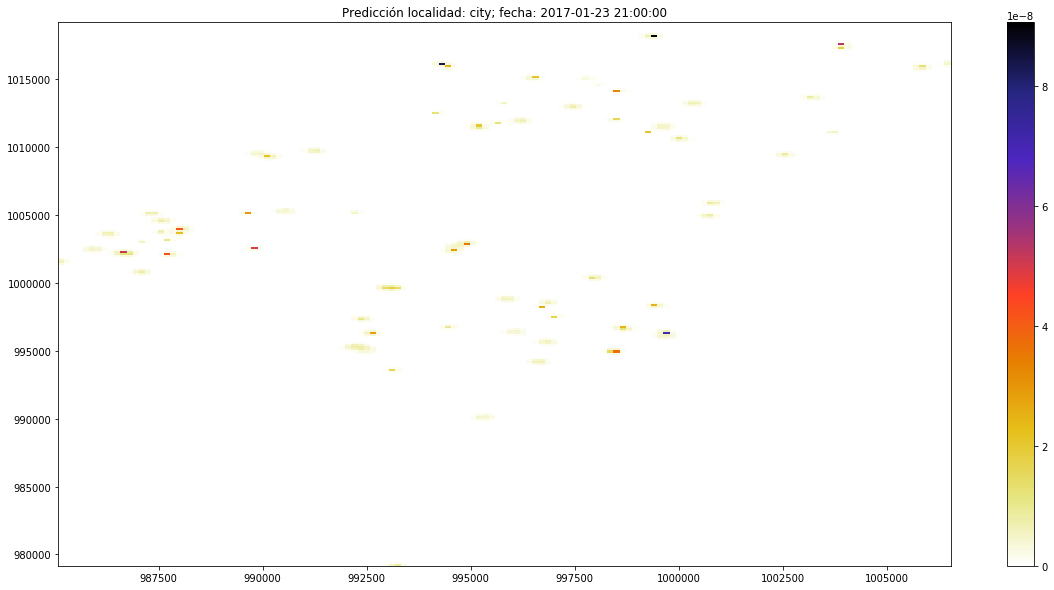

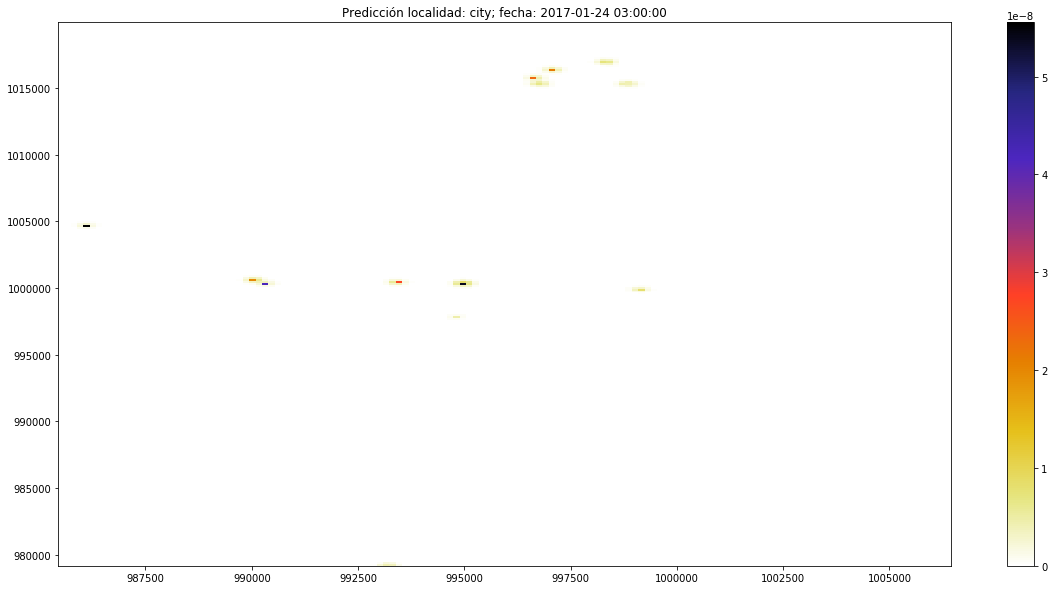

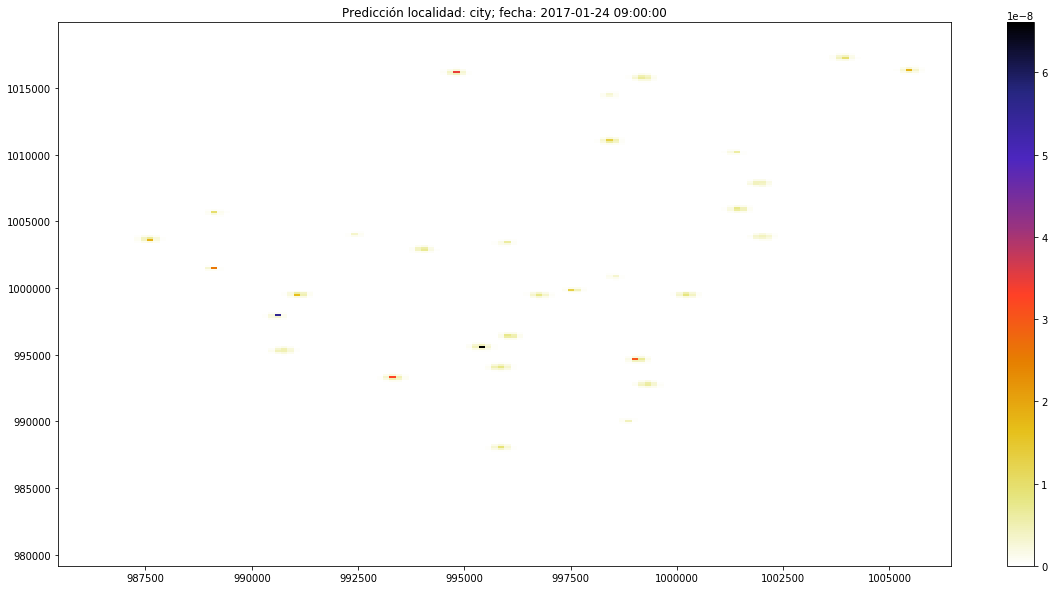

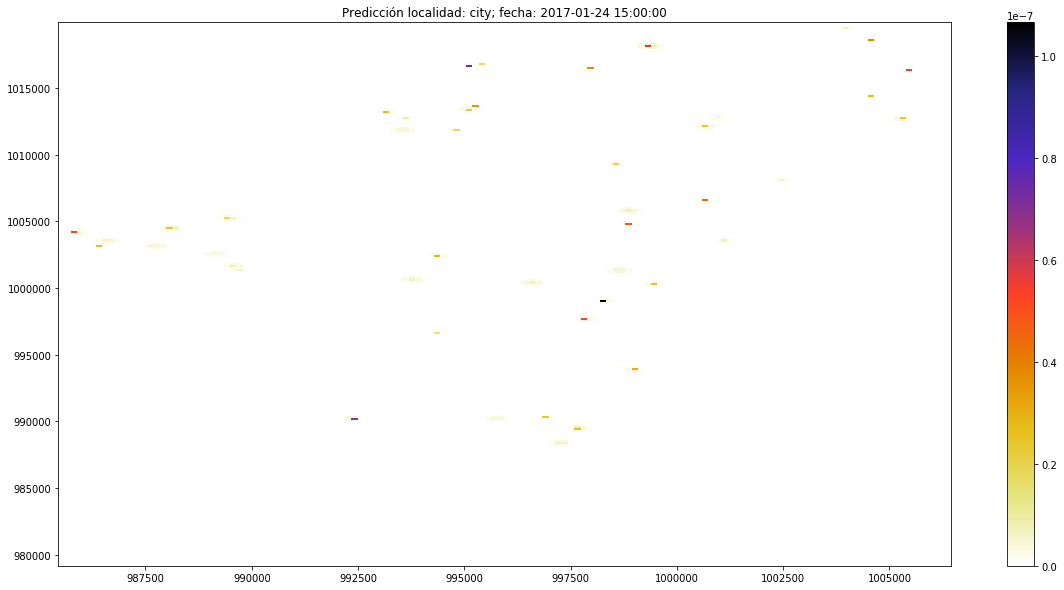

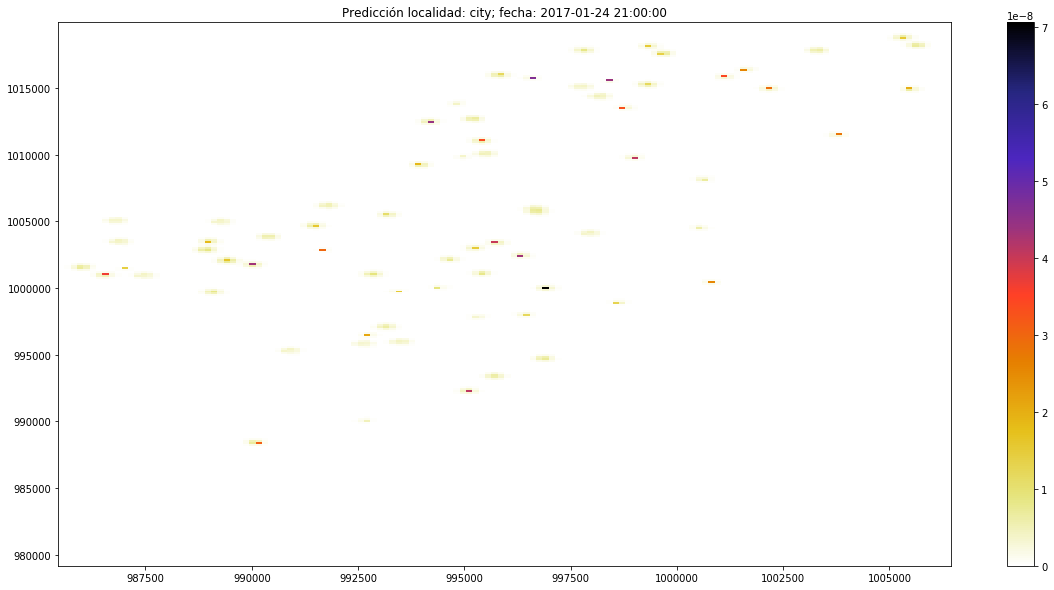

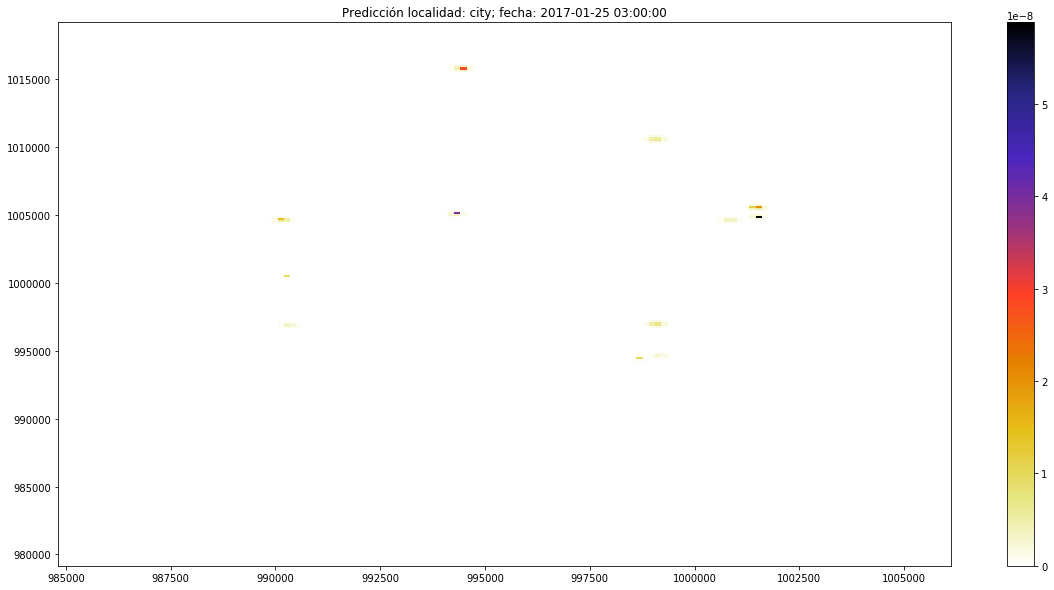

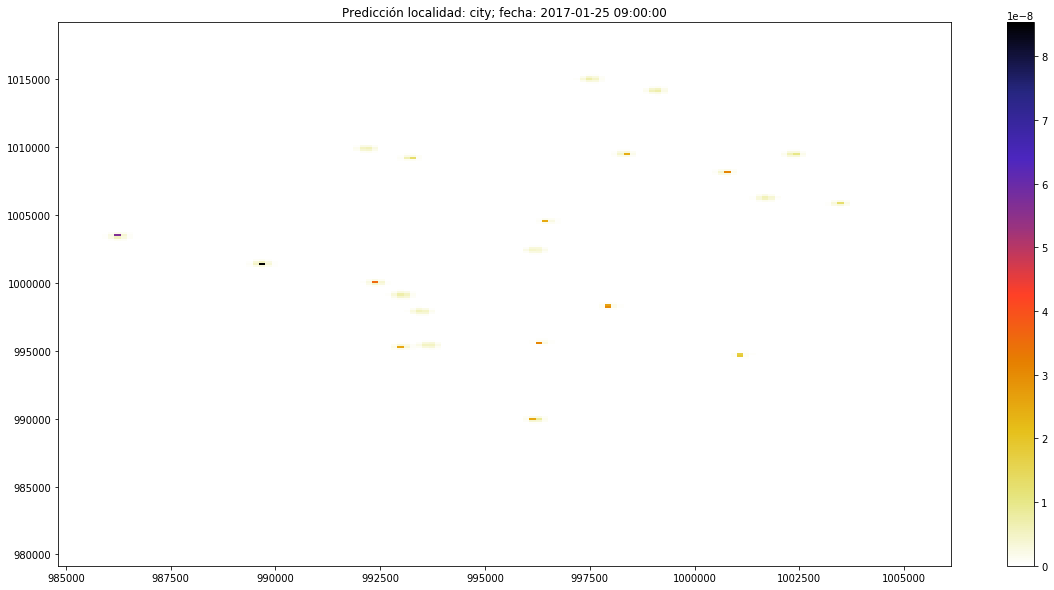

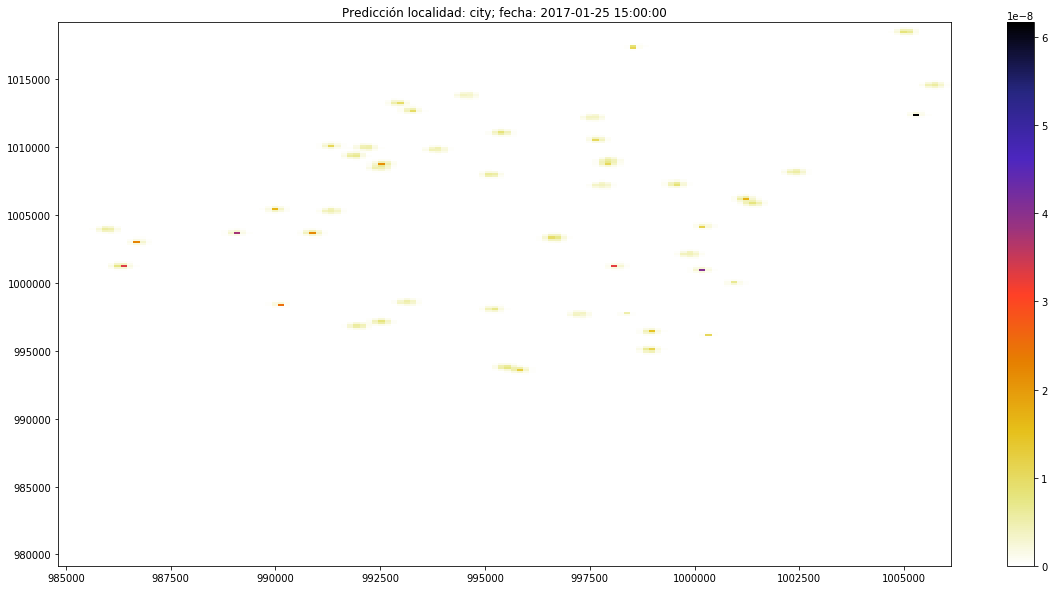

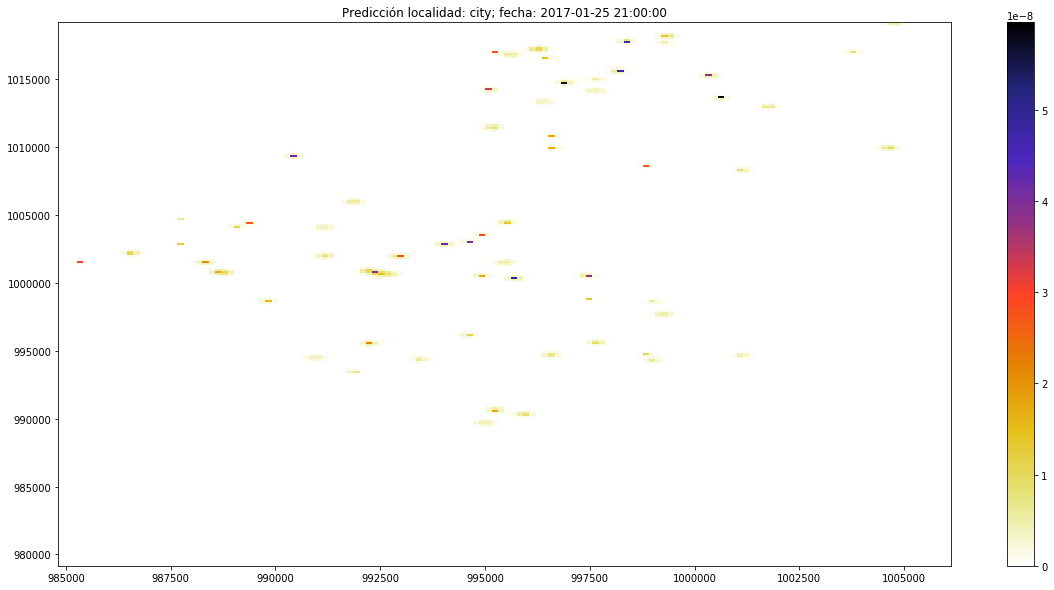

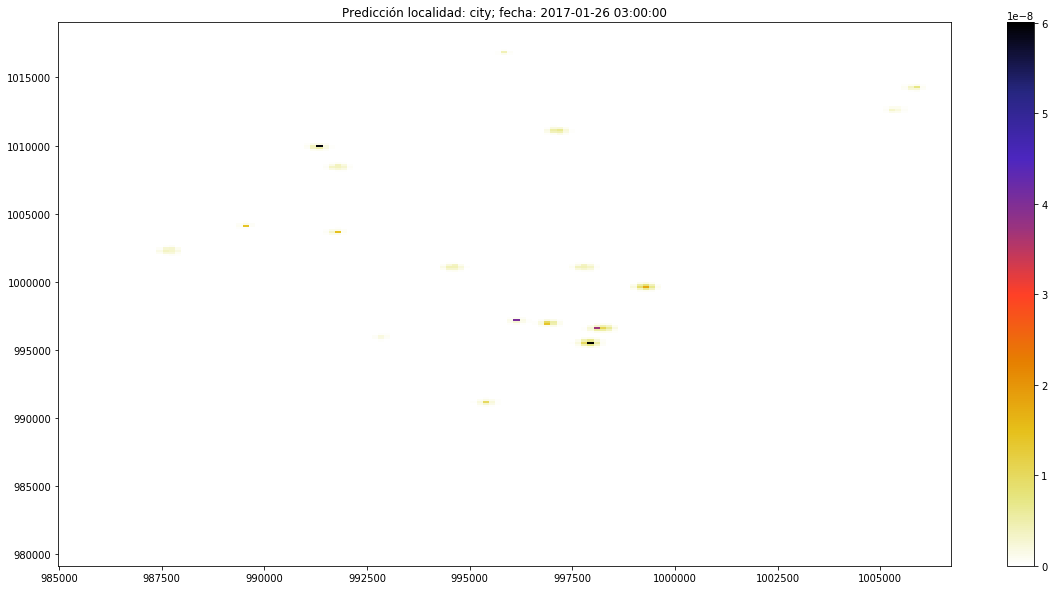

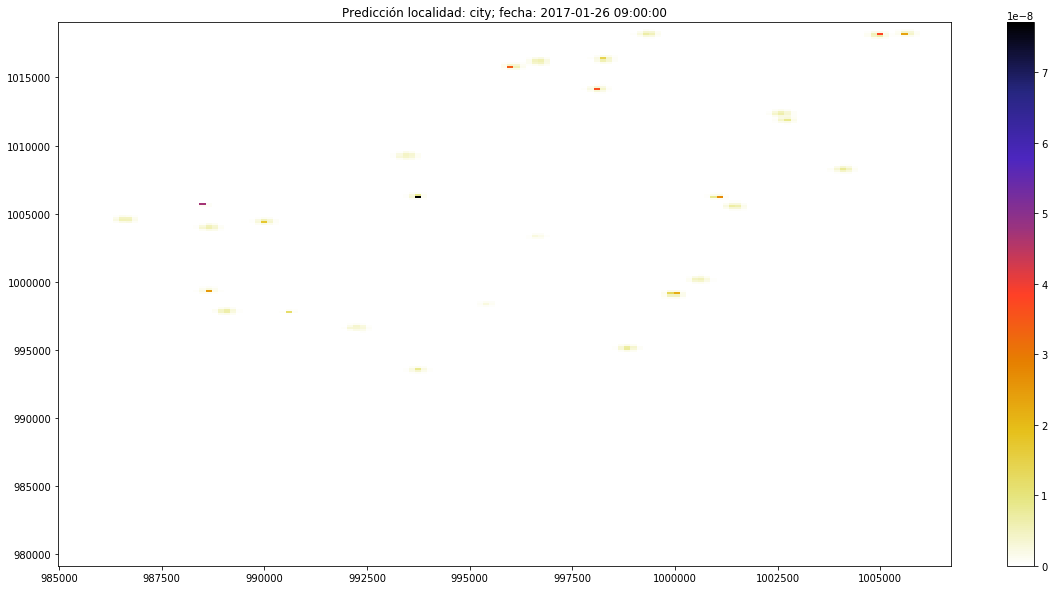

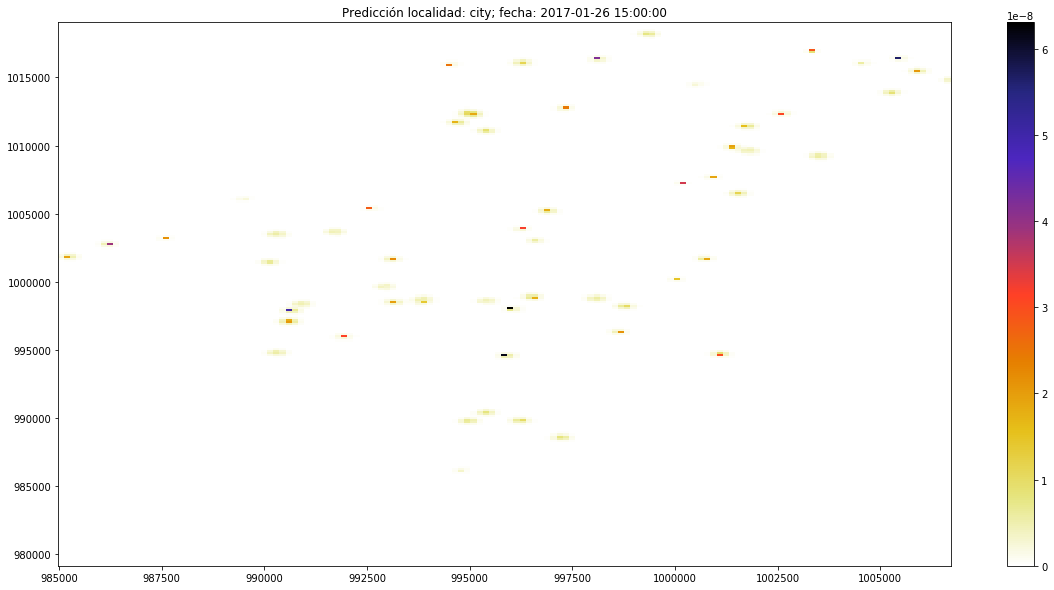

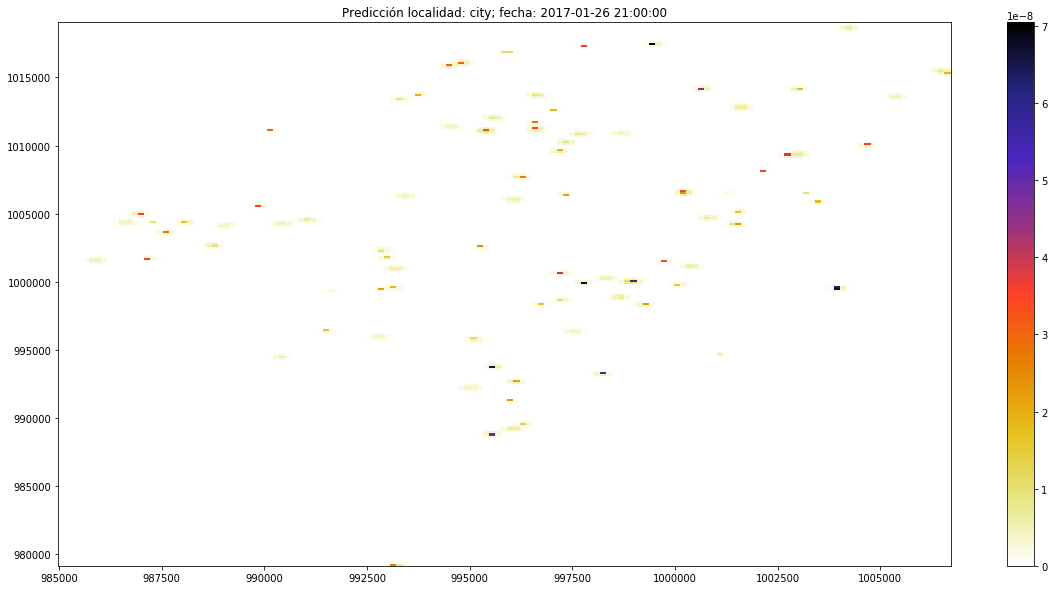

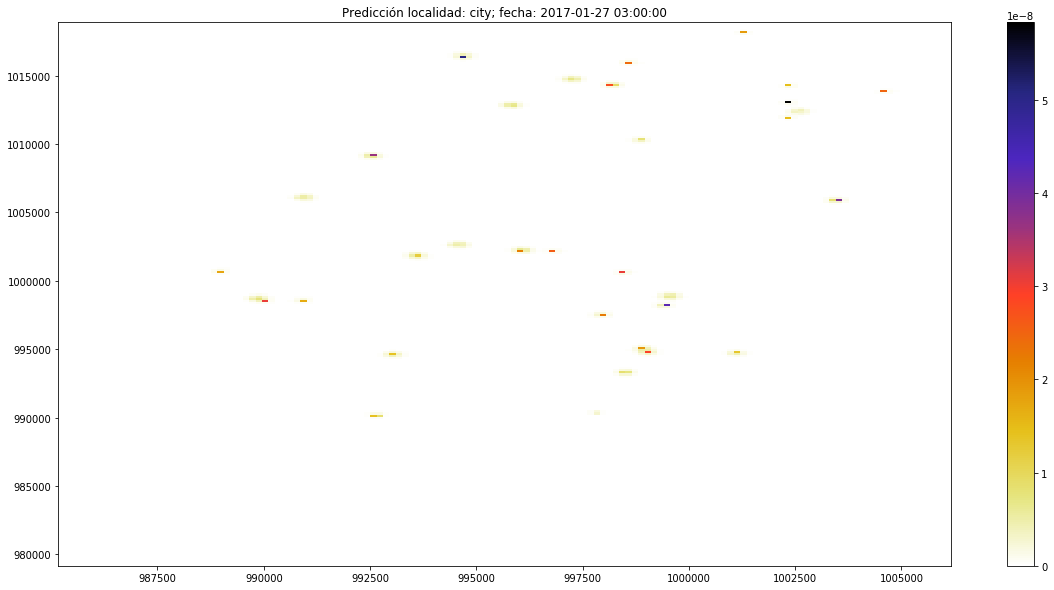

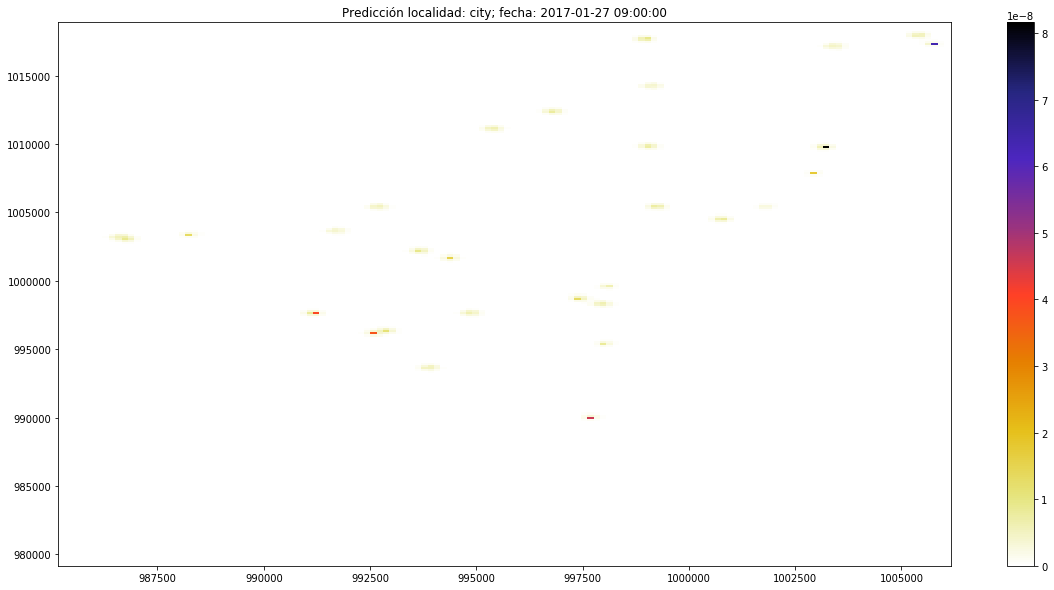

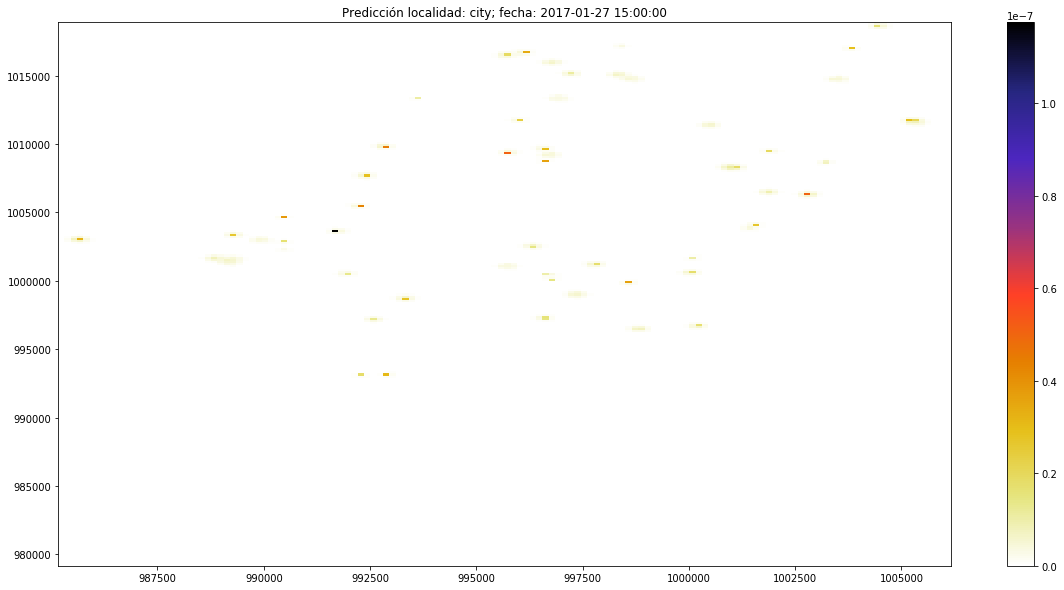

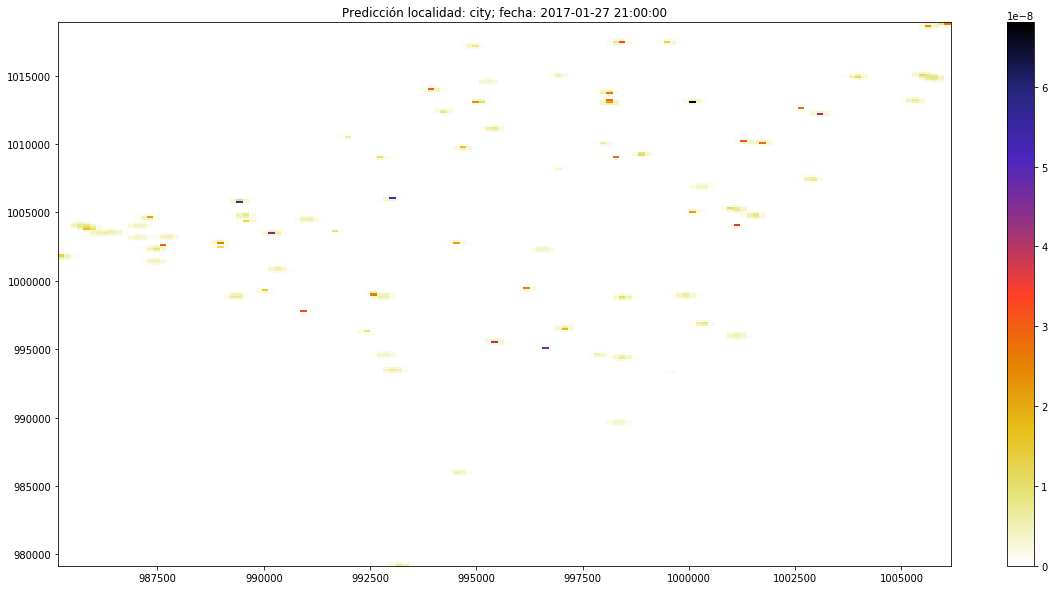

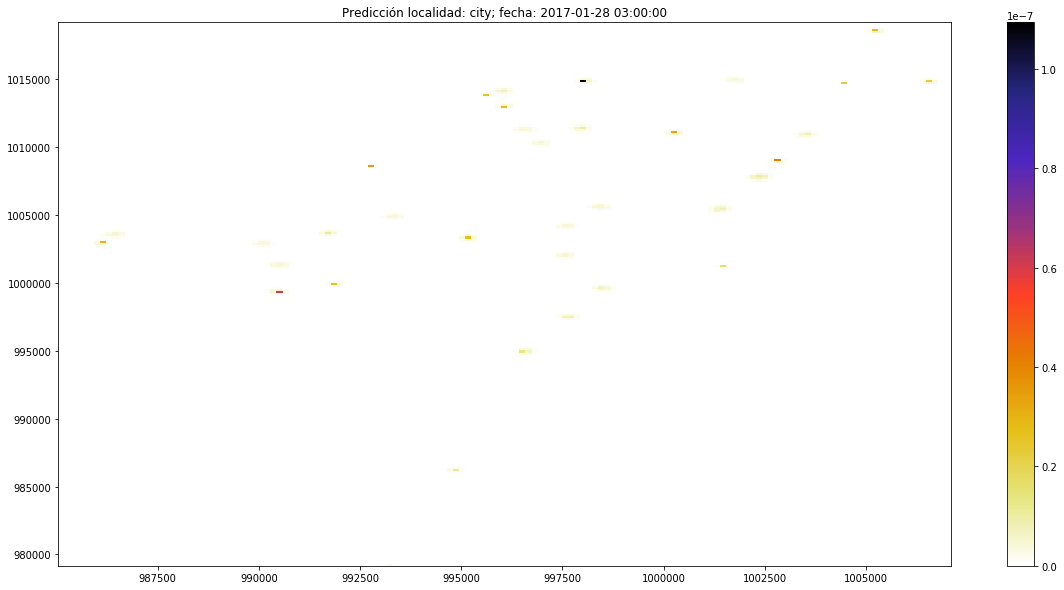

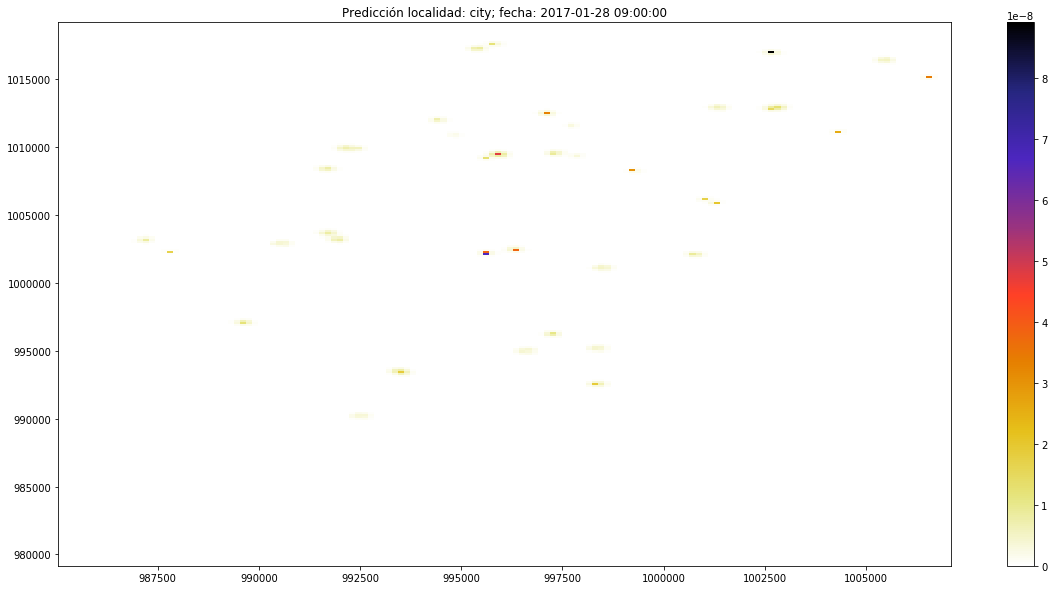

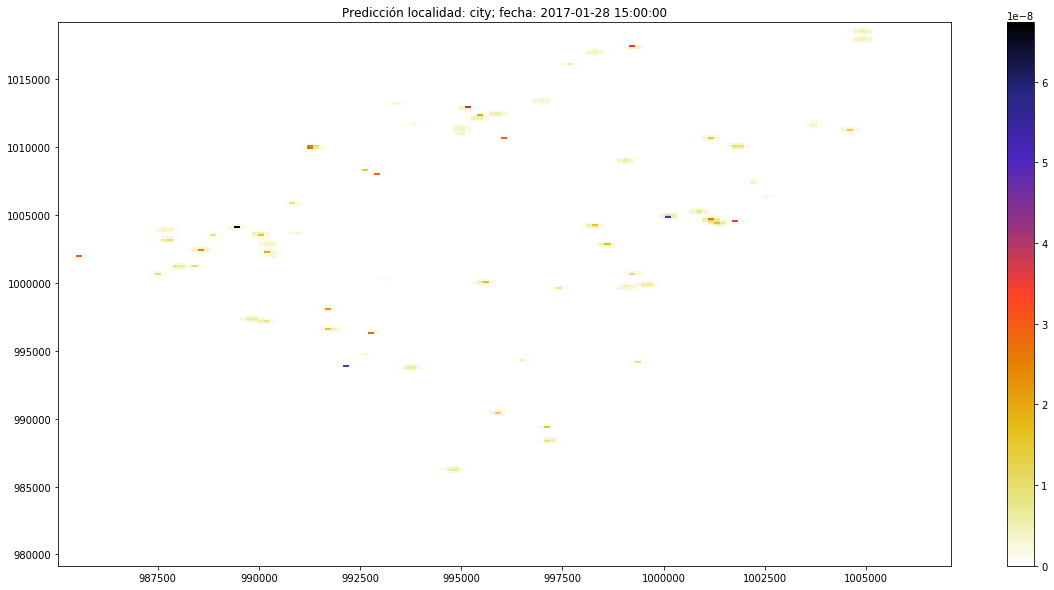

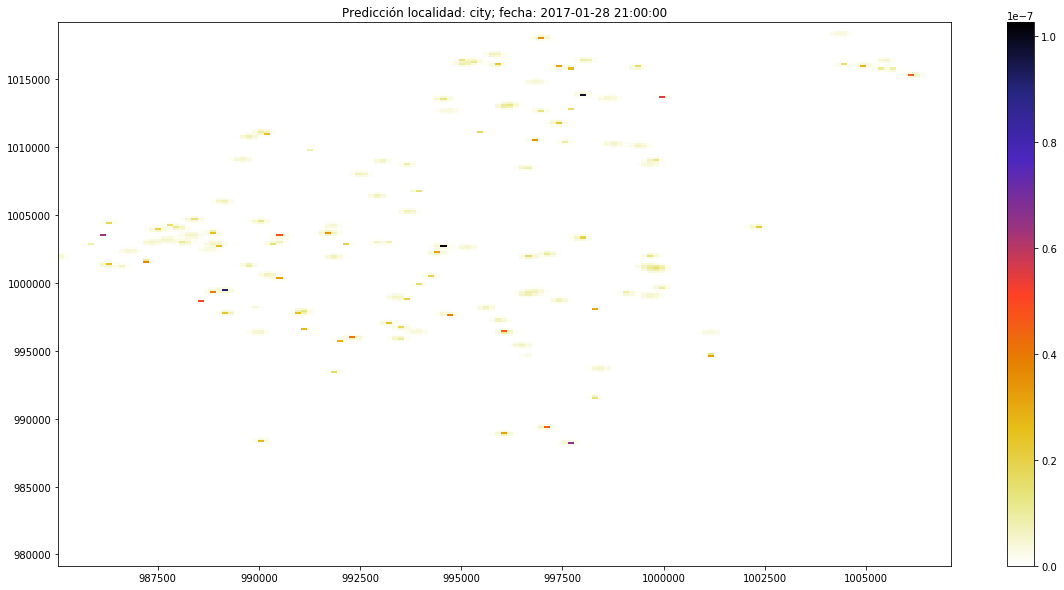

In [73]:
flagF = True
modelCrime = load_model(localidad,trained_model_name)

for initial_date in dates_to_predict:
    hours_timedelta = [3, 9, 15, 21]
    end_date = datetime.datetime.strptime(initial_date,'%Y-%m-%d')+datetime.timedelta(days=1)
    end_date = end_date.strftime('%Y-%m-%d')
    time_window_prediction = {'start':initial_date,'end':end_date}

    for hour_value in hours_timedelta:
        current_date_prediction = time_window_prediction['start']
        predict_time = datetime.datetime.strptime(current_date_prediction,'%Y-%m-%d')+datetime.timedelta(hours=hour_value)
        gridpred, hitrates = run_prediction(localidad,modelCrime,time_window_prediction,predict_time)   
        plot_gridpred(localidad,predict_time,gridpred) ## uncomment to plot gridpred
        predict_time = predict_time.strftime('%Y-%m-%d %H:%M:%S')
        if flagF==True:
            flagF = False
            hitrates_values = np.array([localidad,predict_time,hitrates[0.05],hitrates[0.1]]);
        else:
            hitrates_values = np.vstack((hitrates_values, [localidad,predict_time,hitrates[0.05],hitrates[0.1]]))


In [74]:
df_hitrates = pd.DataFrame(hitrates_values, columns=['localidad','prediction_time','hitrate_0.05','hitrate_0.1'])
df_hitrates

,localidad,prediction_time,hitrate_0.05,hitrate_0.1
0,city,2017-01-22 03:00:00,0.02072538860103627,0.03821243523316062
1,city,2017-01-22 09:00:00,0.016191709844559584,0.02849740932642487
2,city,2017-01-22 15:00:00,0.014896373056994818,0.038860103626943004
3,city,2017-01-22 21:00:00,0.014896373056994818,0.03821243523316062
4,city,2017-01-23 03:00:00,0.02888583218707015,0.04264099037138927
5,city,2017-01-23 09:00:00,0.026134800550206328,0.027510316368638238
6,city,2017-01-23 15:00:00,0.030261348005502064,0.04676753782668501
7,city,2017-01-23 21:00:00,0.0343878954607978,0.07015130674002751
8,city,2017-01-24 03:00:00,0.021246458923512748,0.029745042492917848
9,city,2017-01-24 09:00:00,0.03824362606232295,0.0453257790368272


In [75]:
experiment_name = 'city_hitrates_prediction_2017-01-22_2017-01-28'
hitrates_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl','wb')
pickle.dump(df_hitrates, hitrates_outfile)
hitrates_outfile.close()